In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc, roc_curve
import itertools
import yaml
import os
import numpy as np
from statistics import mean

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Matriz de Confusión',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y plotea la matriz de confusión.
    La normalización se puede aplicar configurando `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()

In [3]:
path = 'mode_train-model_random_forest-trainwindow_38-trainperiod_1-tradingstrategy_strategies.bband_strategy-stop_loss_in_pips_15-periods_forward_target_5'
orders = pd.read_csv(os.path.join('./data', path, 'orders.csv'))
wallet = pd.read_csv(os.path.join('./data', path, 'wallet.csv'))
true_values = pd.read_csv(os.path.join('./data', path, 'stock_true_values.csv'))
predictions = pd.read_csv(os.path.join('./data', path, 'stock_predictions.csv'))

In [4]:
orders

,id,ticker,type,open_date,close_date,open_price,close_price,profit,stop_loss,take_profit,units,profit_in_pips,comment
0,3d839d7e-0c83-11ef-89dd-89ad4012615a,GBPUSD,buy,2024-04-07 22:00:00+00:00,2024-04-08 01:00:00+00:00,1.262220,1.262755,0.356845,1.260720,1.265220,667,0.000535,closed for indicator signal
1,3d83ff34-0c83-11ef-b504-89ad4012615a,EURUSD,buy,2024-04-07 22:00:00+00:00,2024-04-08 01:00:00+00:00,1.082815,1.083535,0.480240,1.081315,1.085815,667,0.000720,closed for indicator signal
2,3e59fe90-0c83-11ef-aeee-89ad4012615a,USDJPY,buy,2024-04-08 06:00:00+00:00,2024-04-08 07:00:00+00:00,151.760000,151.871000,0.777000,151.610000,152.060000,7,0.111000,closed for indicator signal
3,3eba72c5-0c83-11ef-8feb-89ad4012615a,USDJPY,sell,2024-04-08 11:00:00+00:00,2024-04-08 12:00:00+00:00,151.918500,151.879500,0.273000,152.068500,151.618500,7,0.039000,closed for indicator signal
4,3ebac3f1-0c83-11ef-a4ae-89ad4012615a,GBPUSD,buy,2024-04-08 11:00:00+00:00,2024-04-08 12:00:00+00:00,1.261910,1.262635,0.490825,1.260410,1.264910,677,0.000725,closed for indicator signal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,6ae4a428-0c83-11ef-b11a-89ad4012615a,GBPUSD,sell,2024-05-02 19:00:00+00:00,2024-05-03 01:00:00+00:00,1.253650,1.255595,-2.419580,1.255150,1.250650,1244,-0.001945,closed for stop loss
105,6bd062f6-0c83-11ef-89d5-89ad4012615a,USDJPY,buy,2024-05-03 04:00:00+00:00,2024-05-03 05:00:00+00:00,152.917000,152.997500,0.966000,152.767000,153.217000,12,0.080500,closed for indicator signal
106,6bfc2d98-0c83-11ef-9efd-89ad4012615a,EURUSD,buy,2024-05-03 06:00:00+00:00,2024-05-03 07:00:00+00:00,1.072995,1.073460,0.573810,1.071495,1.075995,1234,0.000465,closed for indicator signal
107,6c5fae53-0c83-11ef-8b26-89ad4012615a,USDJPY,sell,2024-05-03 11:00:00+00:00,2024-05-03 12:00:00+00:00,153.203500,152.202500,12.012000,153.353500,152.903500,12,1.001000,closed for indicator signal


In [5]:
orders[orders['profit']<0].agg({'profit':['median', 'std']})

,profit
median,-0.315520
std,1.035459


In [6]:
orders[orders['profit']>0].agg({'profit':['median', 'std']})

,profit
median,0.573810
std,1.418527


In [11]:
orders.comment.value_counts()

comment
closed for indicator signal    106
closed for stop loss             2
Name: count, dtype: int64

In [7]:
with open('configs/project_config.yml', 'r') as archivo:
    config = yaml.safe_load(archivo)

tickers = config["tickers"] 
tickers

predictions = predictions.sort_values(by='fecha')
true_values = true_values.sort_values(by='fecha')


# renombro las columnas
column_names = {}
for column in predictions.columns:
    if column != 'fecha':
        column_names[column] = f'{column}_proba'

predictions = predictions.rename(columns=column_names)

column_names = {}
for column in true_values.columns:
    if column != 'fecha':
        column_names[column] = f'{column}_true'

true_values = true_values.rename(columns=column_names)
performance = pd.concat(
    [
        predictions,
        true_values
    ], axis=1, join="inner"
)

auc_list = []
for ticker in tickers:
    y_true = performance[performance[f'{ticker}_true'].notna()][f'{ticker}_true']
    y_pred = performance[performance[f'{ticker}_proba'].notna()][f'{ticker}_proba']
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    
    auc_list.append(auc_score)
    print(f'{ticker}: {auc_score}')

print(mean(auc_list))

EURUSD: 0.7787334627552488
GBPUSD: 0.7423800904977376
USDJPY: 0.7675663099115868
0.7628932877215244


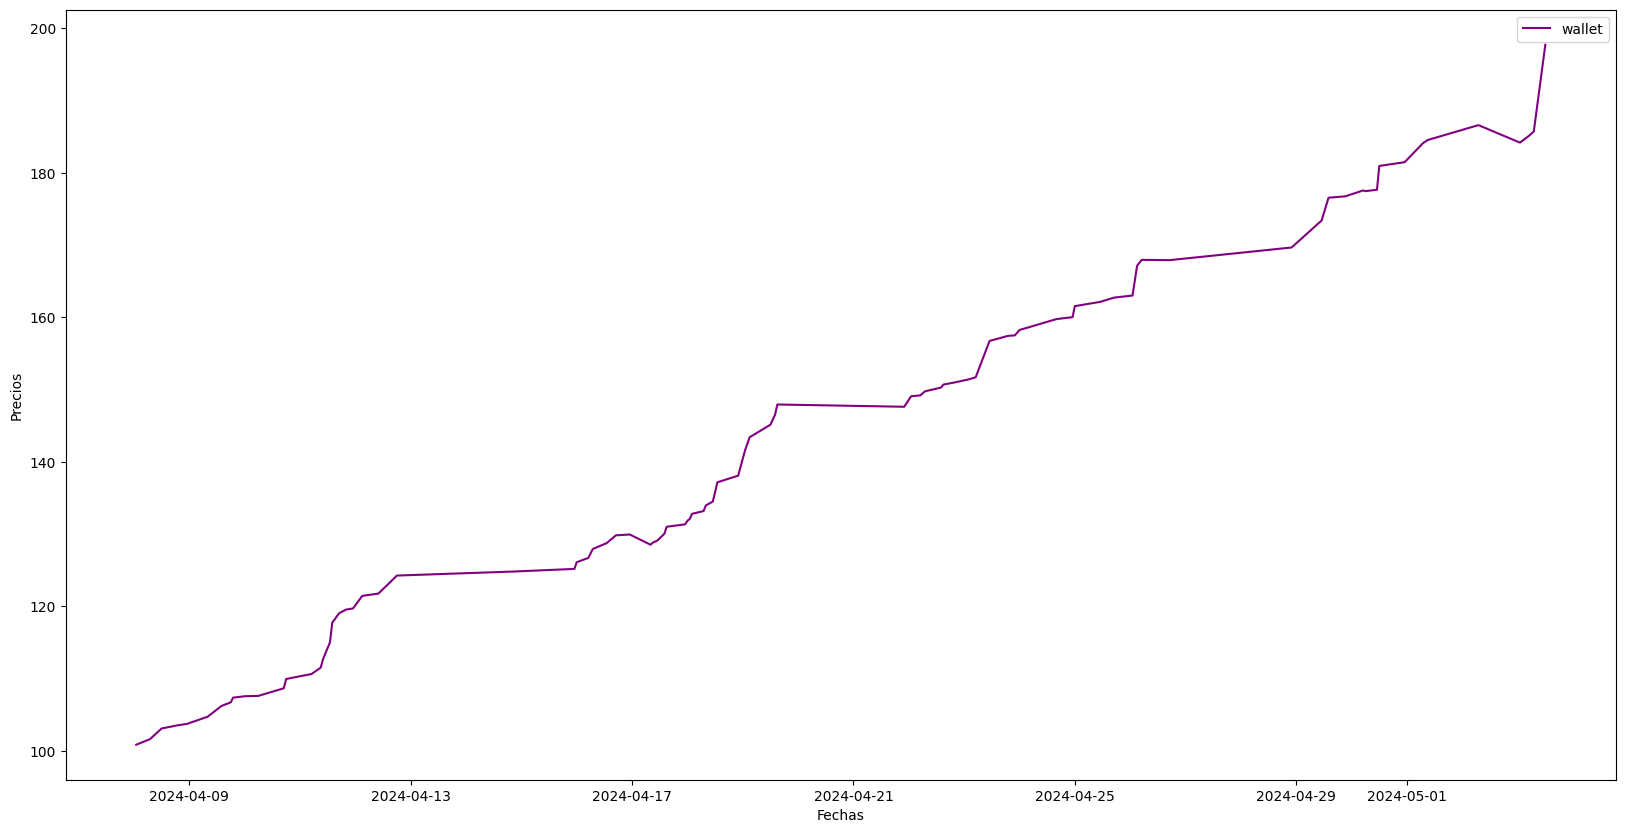

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
x_wallet = pd.to_datetime(wallet['date'])
y_wallet = wallet['wallet']  # Datos para la línea

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Agregar la línea
ax.plot(x_wallet, y_wallet, label='wallet', color='purple')

# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()

# Mostrar el gráfico
plt.show()


# Grafico de velas

In [9]:
# import plotly.graph_objects as go

# fig = go.Figure(data=[go.Candlestick(x=prices['Date'],
#                 open=prices['Open'],
#                 high=prices['High'],
#                 low=prices['Low'],
#                 close=prices['Close'])])

# fig.update_layout(
#     title=f"{config['ticker']}",
#     yaxis_title=f"{config['ticker']} Stock"
# )

# fig.show()

# Estrategia

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
x_prices = pd.to_datetime(prices['Date'])
y_prices = prices['Close']  # Datos para la línea

x_buy = pd.to_datetime(buys['fecha'])
y_buy = buys['buy']  # Datos para el scatter plot

x_sell = pd.to_datetime(sells['date'])
y_sell = sells['sell']  # Datos para el scatter plot

x_wallet = pd.to_datetime(wallet['date'])
y_wallet = wallet['wallet']  # Datos para la línea

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Agregar la línea
ax.plot(x_prices, y_prices, label='market', color='black')

ax.plot(x_wallet, y_wallet, label='wallet', color='purple')

# Agregar el scatter plot
ax.scatter(x_buy, y_buy, label='compras', color='cyan', marker='>')

ax.scatter(x_sell, y_sell, label='Ventas', color='red', marker='o')

# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()

# Mostrar el gráfico
plt.show()


NameError: name 'prices' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
x_prices = pd.to_datetime(prices['Date'])
y_prices = prices['Close']  # Datos para la línea

x_buy = pd.to_datetime(buys['date'])
y_buy = buys['buy']  # Datos para el scatter plot

x_sell = pd.to_datetime(sells['date'])
y_sell = sells['sell']  # Datos para el scatter plot

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Agregar la línea
ax.plot(x_prices, y_prices, label='market', color='black')

# Agregar el scatter plot
ax.scatter(x_buy, y_buy, label='compras', color='cyan', marker='>')

ax.scatter(x_sell, y_sell, label='Ventas', color='red', marker='o')

# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

print('Area bajo la curva: ', auc(wallet.index, wallet['wallet']))

# Datos de ejemplo
x_prices = pd.to_datetime(wallet['date'])
y_prices = wallet['wallet']  # Datos para la línea


# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Agregar la línea
ax.plot(x_prices, y_prices, label='Wallet', color='blue')

# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()

# Mostrar el gráfico
plt.show()


# Modelo

In [ ]:
predictions.sort_values(by='fecha')

In [ ]:
true_values.sort_values(by='fecha')

In [ ]:
accuracy_score(predictions[predictions['YPF'].notna()].YPF, true_values[true_values['YPF'].notna()].YPF)

In [ ]:
threshold_down = 0.5
threshold_up = 0.5

df_predictions = performance[(performance['y_pred']<threshold_down) | (performance['y_pred']>threshold_up)].copy()
df_predictions['y_pred'] = np.where(df_predictions['y_pred']<threshold_down, 0, df_predictions['y_pred'])
df_predictions['y_pred'] = np.where(df_predictions['y_pred']>threshold_up, 1, df_predictions['y_pred'])

print(accuracy_score(df_predictions.y_true, df_predictions.y_pred))
plot_confusion_matrix(df_predictions.y_true, df_predictions.y_pred, classes=[0,1], cmap=plt.cm.Reds)

In [ ]:
threshold_down = 0.1
threshold_up = 0.9

df_predictions = performance[(performance['y_pred']<threshold_down) | (performance['y_pred']>threshold_up)].copy()
df_predictions['y_pred'] = np.where(df_predictions['y_pred']<threshold_down, 0, df_predictions['y_pred'])
df_predictions['y_pred'] = np.where(df_predictions['y_pred']>threshold_up, 1, df_predictions['y_pred'])

print(accuracy_score(df_predictions.y_true, df_predictions.y_pred))
plot_confusion_matrix(df_predictions.y_true, df_predictions.y_pred, classes=[0,1], cmap=plt.cm.Reds)

In [ ]:
plt.hist(performance.y_pred, color='lightgreen', ec='black', bins=50)
plt.show()

In [ ]:
buys = buys.rename(columns={''})

In [ ]:
operations = pd.concat([buys[buys['YPF'].notna()], sells[sells['YPF'].notna()]], axis=1, join="inner")[['fecha','YPF']]
operations

In [ ]:
operations['positive'] = np.where(operations['buy']>operations['sell'], 0, 1)
operations['Profit'] = operations['sell'] - operations['buy'] 
operations['positive'].value_counts()